In [2]:
import pandas as pd
import sklearn as sk
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize 
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score,plot_confusion_matrix,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report




In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# train = pd.read_csv('./data/exoTrain.csv')

# test = pd.read_csv('./data/exoTest.csv')

from google.colab import drive 
drive.mount('/content/gdrive')


train = pd.read_csv('gdrive/My Drive/exoTrain.csv')
test = pd.read_csv('gdrive/My Drive/exoTest.csv')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,...,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,-187.56,-192.88,-182.76,...,-167.69,-56.86,7.56,37.40,-81.13,-20.10,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.90,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,-13.87,-29.10,-34.29,...,-36.75,-15.49,-13.24,20.46,-1.47,-0.40,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.80,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,469.66,462.30,492.23,441.20,483.17,481.28,535.31,554.34,562.80,540.14,576.34,551.67,556.69,550.86,577.33,562.08,577.97,530.67,553.27,538.33,527.17,532.50,273.66,273.66,292.39,298.44,252.64,233.58,171.41,...,-51.09,-33.30,-61.53,-89.61,-69.17,-86.47,-140.91,-84.20,-84.20,-89.09,-55.44,-61.05,-29.17,-63.80,-57.61,2.70,-31.25,-47.09,-6.53,14.00,14.00,-25.05,-34.98,-32.08,-17.06,-27.77,7.86,-70.77,-64.44,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,311.14,326.19,313.11,313.89,317.96,330.92,341.10,360.58,370.29,369.71,339.00,336.24,319.31,321.56,308.02,296.82,279.34,275.78,289.67,281.33,285.37,281.87,88.75,88.75,67.71,74.46,69.34,76.51,80.26,...,-2.75,14.29,-14.18,-25.14,-13.43,-14.74,2.24,-31.07,-31.07,-50.27,-39.22,-51.33,-18.53,-1.99,10.43,-1.97,-15.32,-23.38,-27.71,-36.12,-36.12,-15.65,6.63,10.66,-8.57,-8.29,-21.90,-25.80,-29.86,7.42,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,-933.30,-889.49,-888.66,-853.95,-800.91,-754.48,-717.24,-649.34,-605.71,-575.62,-526.37,-490.12,-458.73,-447.76,-419.54,-410.76,-404.10,-425.38,-397.29,-412.73,-446.49,-413.46,-1006.21,-1006.21,-973.29,-986.01,-975.88,-982.20,-953.73,...,-694.76,-705.01,-625.24,-604.16,-668.26,-742.18,-820.55,-874.76,-874.76,-853.68,-808.62,-777.88,-712.62,-694.01,-655.74,-599.74,-617.30,-602.98,-539.29,-672.71,-672.71,-594.49,-597.60,-560.77,-501.95,-461.62,-468.59,-513.24,-504.70,-521.95,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


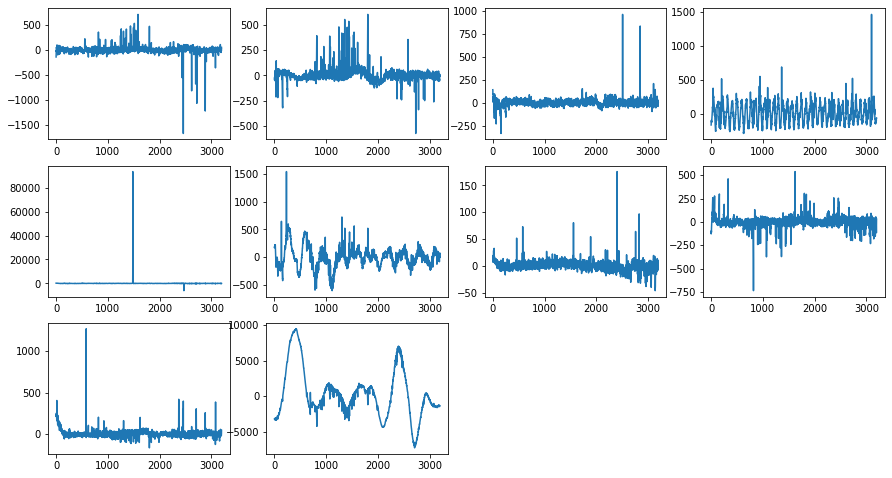

In [17]:
# visualizing non-exoplanet-stars
fig = plt.figure(figsize=(15,40))
x = np.array(range(3197))
for i in range(10):
    ax = fig.add_subplot(14,4,i+1)
    ax.plot(x,train[train.LABEL == 1].iloc[i,1:])





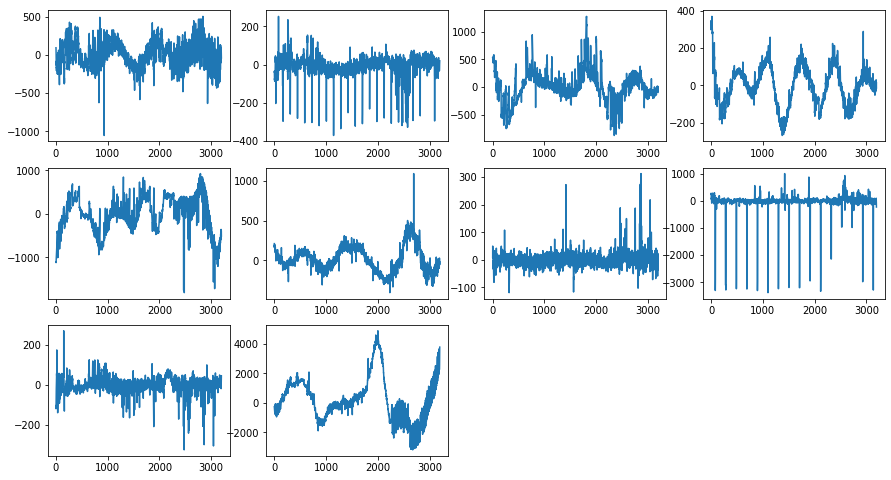

In [18]:
# visualizing exoplanet-stars: trend over time is approximately periodic and outliers are present
fig = plt.figure(figsize=(15,40))
x = np.array(range(3197))
for i in range(10):
    ax = fig.add_subplot(14,4,i+1)
    ax.plot(x,train[train.LABEL == 2].iloc[i,1:])


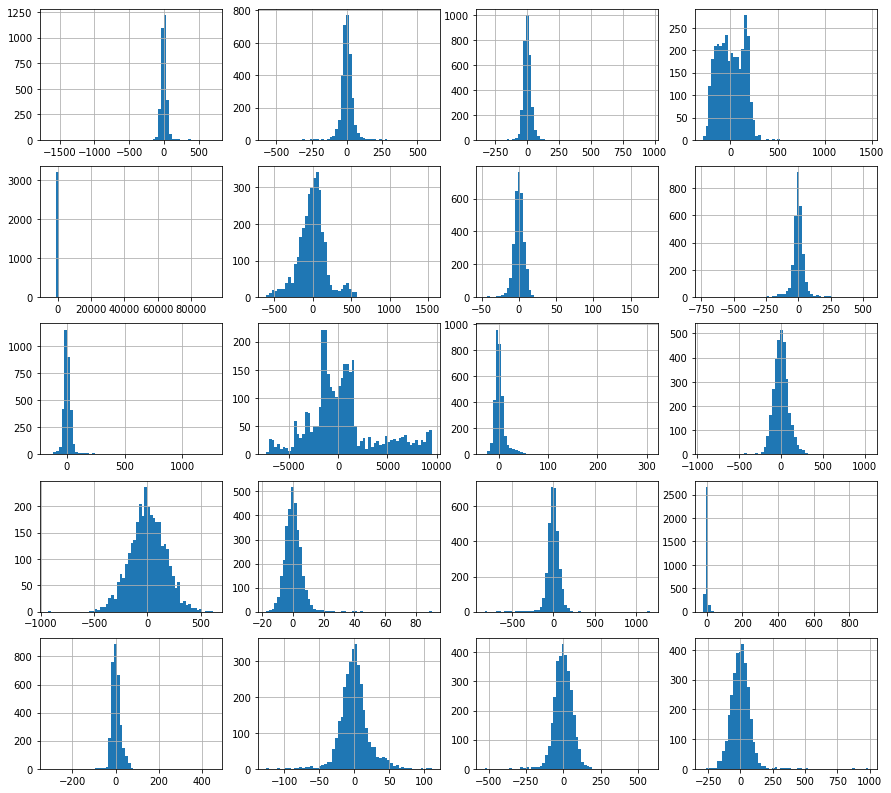

In [19]:
# visualizing flux distribution of non-exoplanet-stars: narrower distribution b/c flux values are more consistent
fig = plt.figure(figsize=(15,40))
for i in range(20):
    ax = fig.add_subplot(14,4,i+1)
    train[train.LABEL ==1].iloc[i,1:].hist(bins=60)


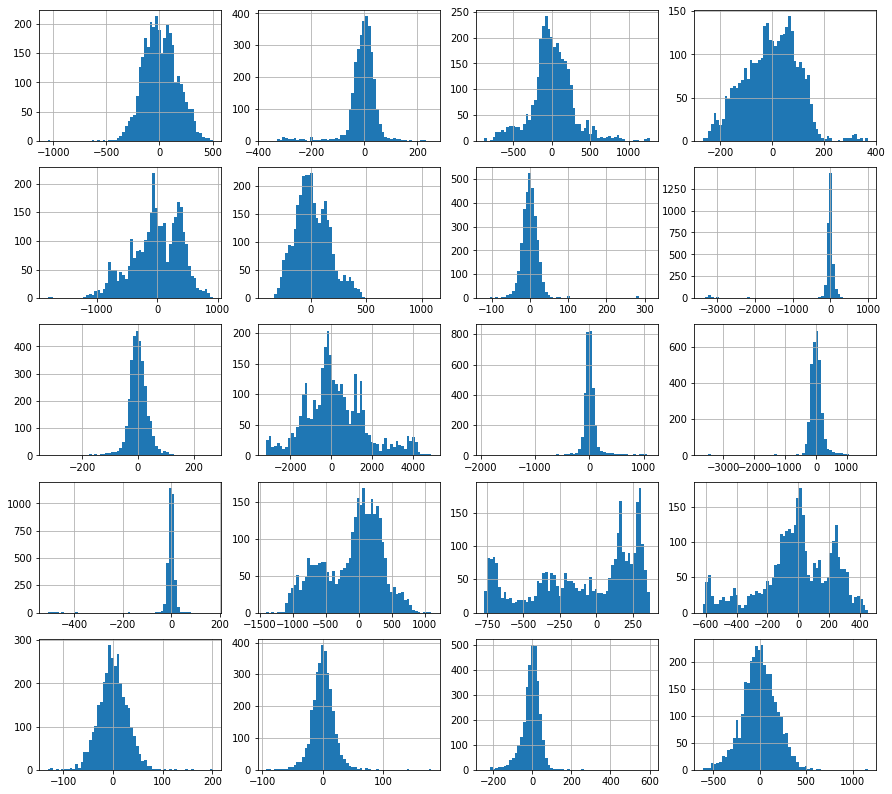

In [20]:
# visualizing flux distribution of exoplanet-stars: wider distribution b/c flux values vary more 
fig = plt.figure(figsize=(15,40))
for i in range(20):
    ax = fig.add_subplot(14,4,i+1)
    train[train.LABEL ==2].iloc[i,1:].hist(bins=60)

In [21]:
from sklearn.model_selection import train_test_split

y_train = train['LABEL']
X_train = train[train.columns[1:]]

y_test = test['LABEL']
X_test = test[train.columns[1:]]
print('LABEL' not in X_train.columns) ## check that we didn't include the labels
print('LABEL' not in X_test.columns) ## check that we didn't include the labels

True
True


In [22]:
# train split
y_train.value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

In [23]:
# baseline model w/o any processing
from sklearn import svm
svm = svm.SVC(kernel = 'rbf')
svm.fit(X_train,y_train)
preds = svm.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



In [24]:
preds_train = svm.predict(X_train)
print(classification_report(y_train,preds_train))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      5050
           2       0.00      0.00      0.00        37

    accuracy                           0.99      5087
   macro avg       0.50      0.50      0.50      5087
weighted avg       0.99      0.99      0.99      5087



In [25]:
# we will do a heavy amount of feature engineering

In [26]:
y_test.value_counts()

1    565
2      5
Name: LABEL, dtype: int64

In [27]:
from imblearn.over_sampling import SMOTE
from collections import Counter
oversample = SMOTE()
X_sampled, y_sampled = oversample.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_sampled)
print(counter)

Counter({2: 5050, 1: 5050})


In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_sampled)
X_embedded.shape

In [ ]:
plt.figure(figsize = (20,10))
plt.title('TSNE reduction with SMOTE')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_sampled)
plt.colorbar()
plt.grid()
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [ ]:
# one can clearly identify the positive samples generated by SMOTE in the tsne reduction

In [ ]:
# separate model with processing
from sklearn import svm
svm = svm.SVC(kernel = 'rbf', probability = True)
svm.fit(X_sampled,y_sampled)
preds = svm.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



In [ ]:
preds_train = svm.predict(X_sampled)
print(classification_report(y_sampled,preds_train))

              precision    recall  f1-score   support

           1       0.52      1.00      0.68      5050
           2       0.94      0.07      0.13      5050

    accuracy                           0.53     10100
   macro avg       0.73      0.53      0.40     10100
weighted avg       0.73      0.53      0.40     10100



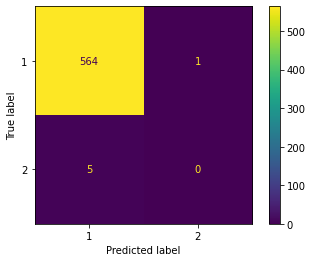

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svm, X_test, y_test)

In [ ]:
subset = X_sampled[y_sampled==2]
probs = svm.predict_proba(subset)

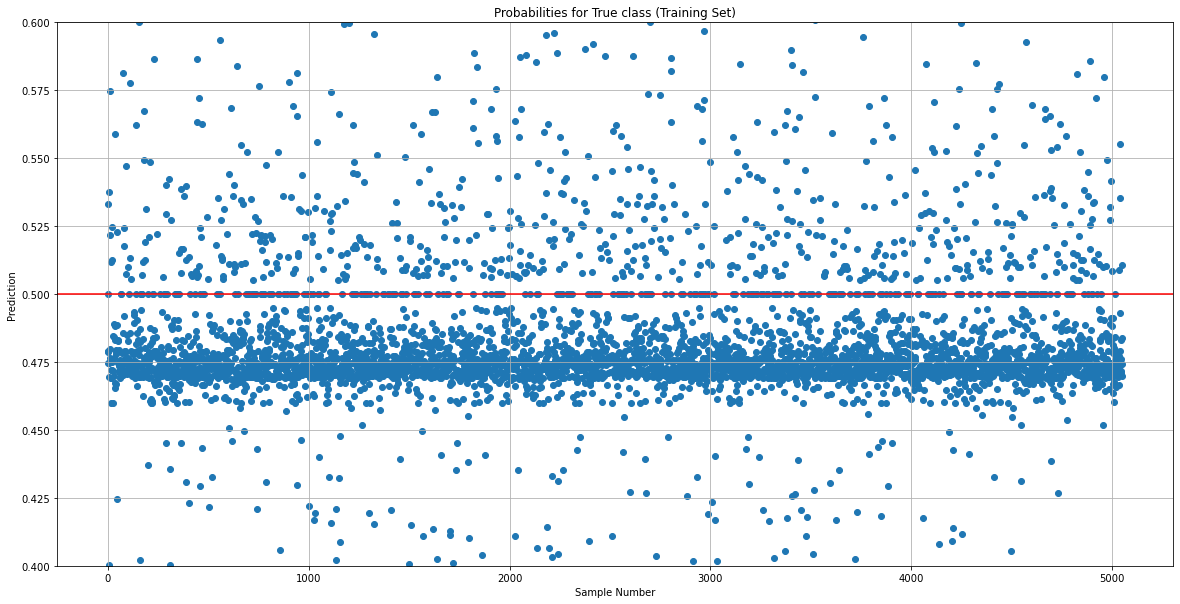

In [ ]:
plt.figure(figsize = (20,10))

plt.scatter(list(range(0,probs.shape[0])), probs[:,1])
plt.axhline(0.5, color = 'r')
plt.ylim(0.4,0.6)
plt.title('Probabilities for True class (Training Set)')
plt.ylabel('Prediction')
plt.xlabel('Sample Number')
plt.grid()

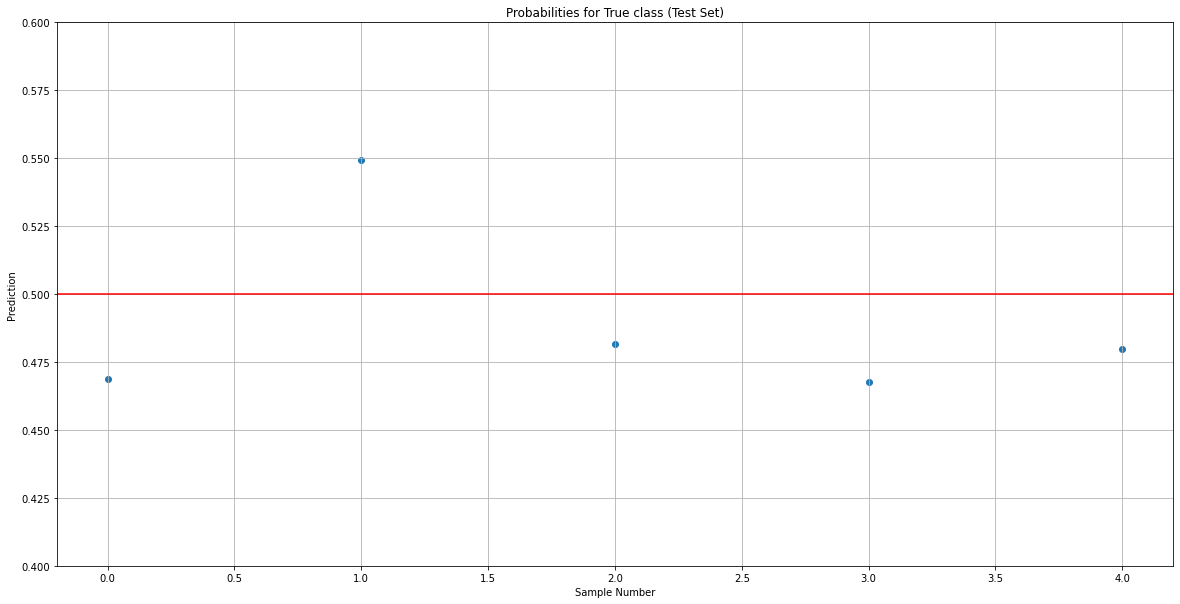

In [ ]:
subset = X_test[y_test==2]
probs = svm.predict_proba(subset)
plt.figure(figsize = (20,10))

plt.scatter(list(range(0,probs.shape[0])), probs[:,1])
plt.axhline(0.5, color = 'r')
plt.ylim(0.4,0.6)
plt.title('Probabilities for True class (Test Set)')
plt.ylabel('Prediction')
plt.xlabel('Sample Number')
plt.grid()

In [ ]:
test_probs = svm.predict_proba(X_test)

In [ ]:
test_preds = [2 if test_probs[i,1]>0.470 else 1 for i in range(0,len(test_probs))]
test_preds2= [2 if test_probs[i,1]>0.475 else 1 for i in range(0,len(test_probs))]
test_preds3 = [2 if test_probs[i,1]>0.485 else 1 for i in range(0,len(test_probs))]

Counter(test_preds)

Counter({1: 209, 2: 361})

In [ ]:
print(classification_report(y_test,test_preds))
print(classification_report(y_test,test_preds2))
print(classification_report(y_test,test_preds3))

              precision    recall  f1-score   support

           1       0.99      0.37      0.53       565
           2       0.01      0.60      0.02         5

    accuracy                           0.37       570
   macro avg       0.50      0.48      0.28       570
weighted avg       0.98      0.37      0.53       570

              precision    recall  f1-score   support

           1       1.00      0.84      0.91       565
           2       0.03      0.60      0.06         5

    accuracy                           0.84       570
   macro avg       0.51      0.72      0.49       570
weighted avg       0.99      0.84      0.90       570

              precision    recall  f1-score   support

           1       0.99      0.94      0.96       565
           2       0.03      0.20      0.05         5

    accuracy                           0.93       570
   macro avg       0.51      0.57      0.51       570
weighted avg       0.98      0.93      0.96       570



<AxesSubplot:>

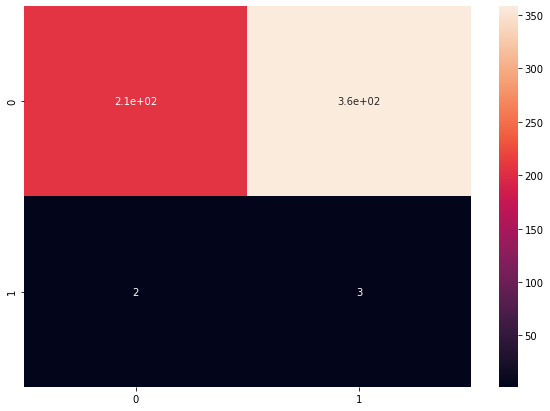

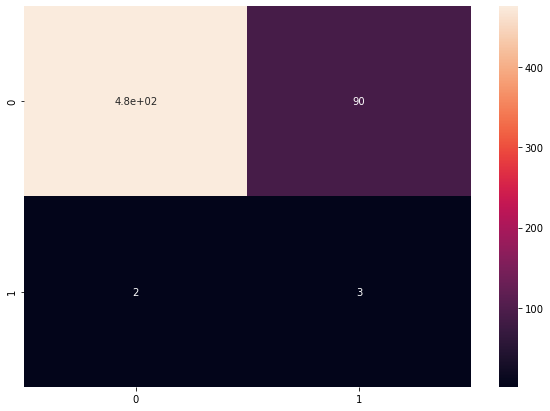

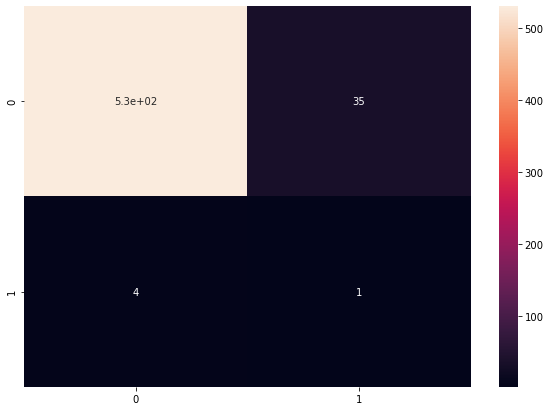

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

plt.figure(figsize = (10,7))
cm = confusion_matrix(y_test, test_preds)
sn.heatmap(cm, annot=True)


plt.figure(figsize = (10,7))
cm = confusion_matrix(y_test, test_preds2)
sn.heatmap(cm, annot=True)

plt.figure(figsize = (10,7))
cm = confusion_matrix(y_test, test_preds3)
sn.heatmap(cm, annot=True)

In [ ]:
# signal processing
from scipy import fftpack

fs = 3
sample = X_sampled.iloc[1000] 
fft_wave = np.fft.fft(sample)

# Compute the Discrete Fourier Transform sample frequencies.

fft_fre = np.fft.fftfreq(n=sample.shape[0], d=1/fs)

Text(0.5, 1.0, 'FFT in Frequency Domain')

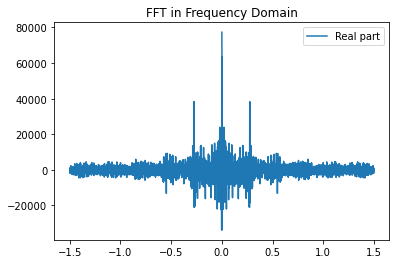

In [ ]:
plt.plot(fft_fre, fft_wave.real, label="Real part")

plt.legend(loc=1)
plt.title("FFT in Frequency Domain")

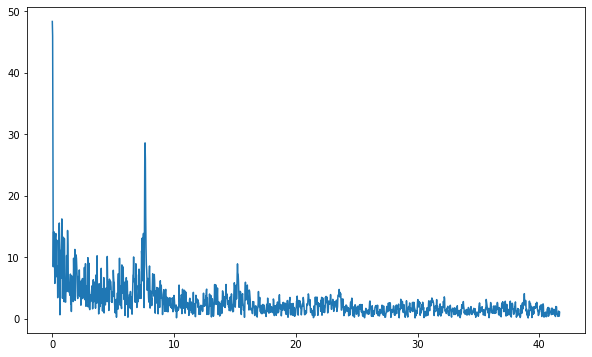

In [ ]:
yf = fftpack.fft(sample.values, len(sample))

amp = np.abs(yf) # get amplitude spectrum 
freq = np.linspace(0.0, 1.0/(2.0*(6/500)), len(sample)//2) # get freq axis

# plot the amp spectrum

plt.figure(figsize=(10,6))
plt.plot(freq, (2/amp.size)*amp[0:amp.size//2])
plt.show()

In [9]:
from scipy.signal import detrend

def remove_noise(data):
    import scipy.signal as signal
    N  = 3    
    Wn = 0.15
    B, A = signal.butter(N, Wn, output='ba')
    smooth_data = signal.filtfilt(B,A, data)
    return smooth_data

In [10]:
X_sampled = pd.DataFrame(X_sampled)

In [11]:
from scipy.signal import butter,filtfilt
from scipy import signal
import matplotlib.pyplot as plt

def apply_bandpass(sig):
    # Filter requirements.
    fs = 30.0       # sample rate, Hz
    T = len(sig)/fs       # Sample Period
    cutoff = [0.1, 2.5] #0.3-0.45 for resting
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2  # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    def butter_bandpass_filter(data, cutoff, fs, order):
       # normal_cutoff = cutoff / nyq
        # Get the filter coefficients 
        b, a = butter(order, [cutoff[0]/nyq, cutoff[1]/nyq], btype='bandpass', analog=False)
        y = filtfilt(b, a, data)
        return y
    y = butter_bandpass_filter(sig, cutoff, fs, order)
    return signal.detrend(y)

Text(0.5, 1.0, 'Bandpass Filtering, label = 2')

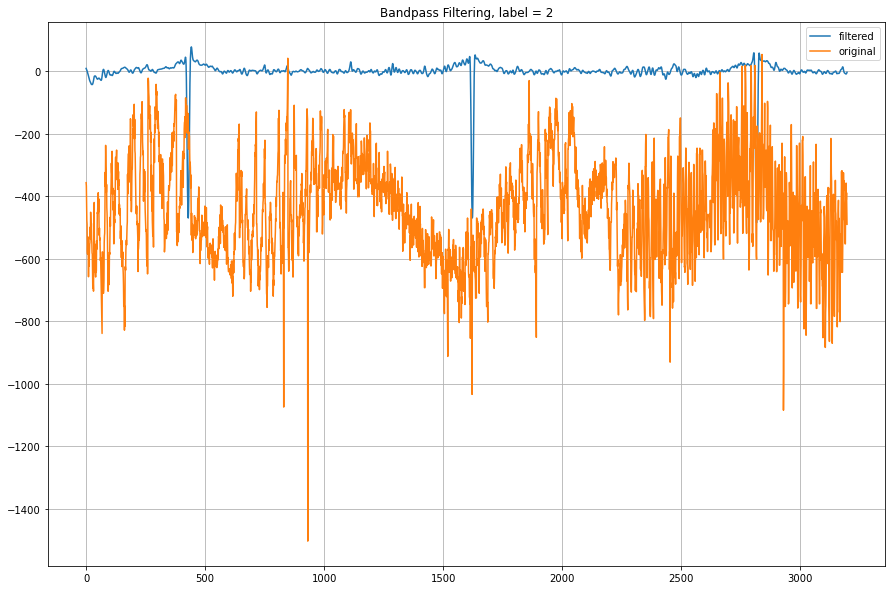

In [ ]:
t1 = apply_bandpass(X_sampled.iloc[12].values)

plt.figure(figsize = (15,10))
plt.plot(signal.detrend(t1), label = 'filtered')
plt.plot(X_sampled.iloc[0].values-450, label = 'original')
plt.legend()
plt.grid()
plt.title('Bandpass Filtering, label = {}'.format(str(y_sampled.iloc[12])))

Text(0.5, 1.0, 'Bandpass Filtering, label = 1')

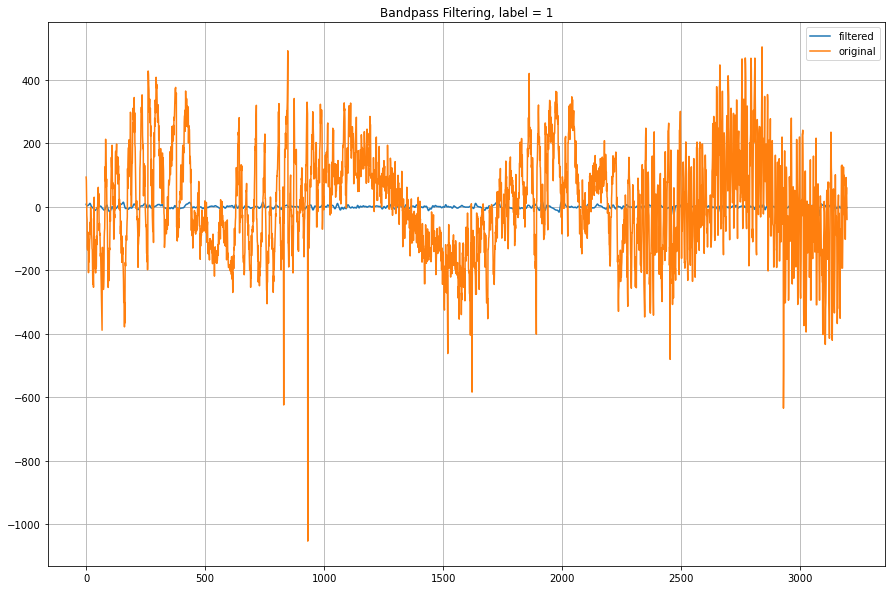

In [ ]:
t1 = apply_bandpass(X_sampled.iloc[230].values)

plt.figure(figsize = (15,10))
plt.plot(signal.detrend(t1), label = 'filtered')
plt.plot(X_sampled.iloc[0].values, label = 'original')
plt.legend()
plt.grid()
plt.title('Bandpass Filtering, label = {}'.format(str(y_sampled.iloc[230])))

Text(0.5, 1.0, 'Bandpass Filtering, label = 2')

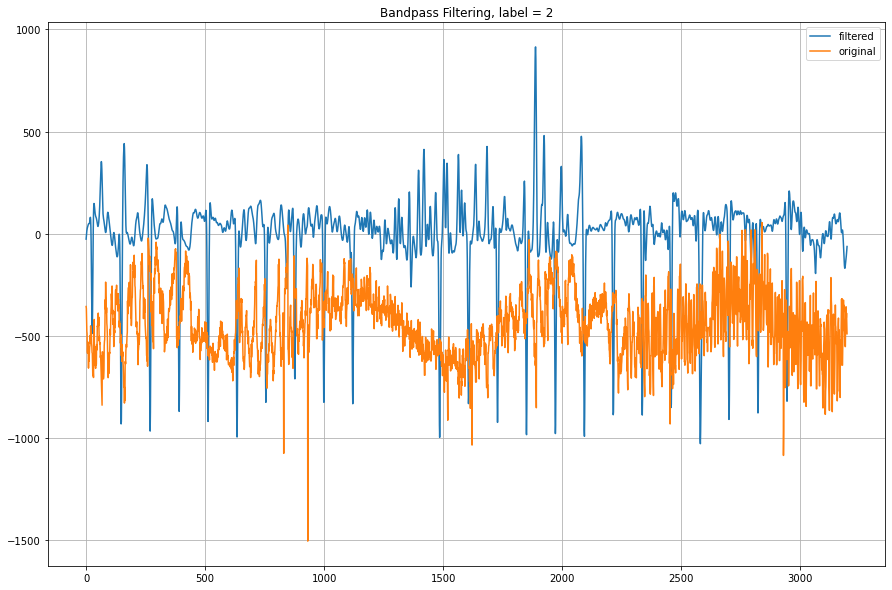

In [ ]:
idx = 5950
t1 = apply_bandpass(X_sampled.iloc[idx].values)

plt.figure(figsize = (15,10))
plt.plot(signal.detrend(t1), label = 'filtered')
plt.plot(X_sampled.iloc[0].values-450, label = 'original')
plt.legend()
plt.grid()
plt.title('Bandpass Filtering, label = {}'.format(str(y_sampled.iloc[idx])))

In [ ]:
X_sampled.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [160]:
X_new_sampled = X_sampled.apply(apply_bandpass, axis = 1)
X_new_test = X_test.apply(apply_bandpass, axis = 1)


Text(0.5, 1.0, 'Bandpass Filtering, label = 2')

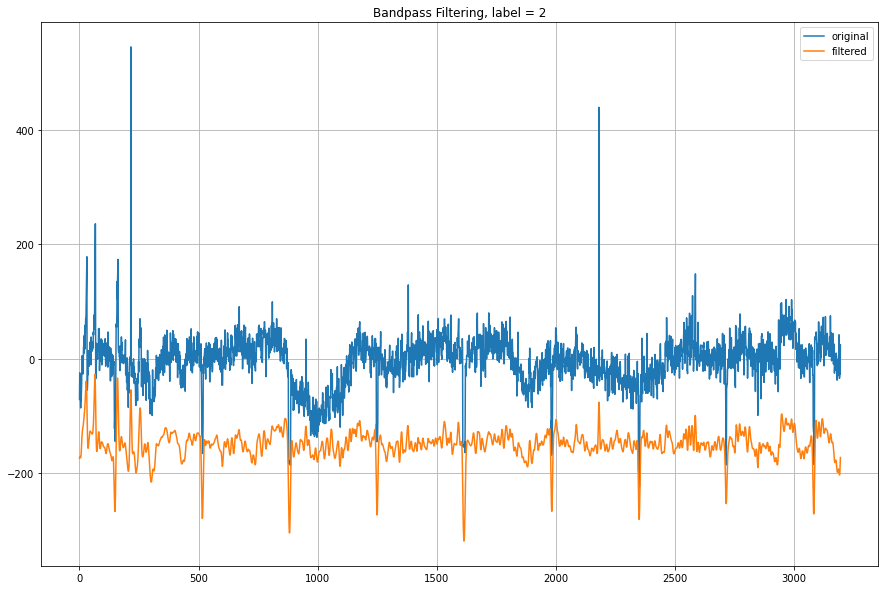

In [69]:
plt.figure(figsize = (15,10))
idx = 7670
plt.plot(X_sampled.iloc[idx].values, label = 'original')
plt.plot(X_new_sampled.iloc[idx]-150, label = 'filtered')
plt.legend()
plt.grid()
plt.title('Bandpass Filtering, label = {}'.format(str(y_sampled[idx])))

In [70]:
X_new_sampled = np.stack(X_new_sampled.values)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn import svm


#X_new_sampled = StandardScaler().fit_transform(X_new_sampled)
clf = MLPClassifier(random_state=1, max_iter=300, verbose = 3).fit(X_new_sampled, y_sampled)

# predict the labels of the test data 
#preds = classifier.predict(X_test)


Iteration 1, loss = 0.65488782
Iteration 2, loss = 0.59202382
Iteration 3, loss = 0.55596070
Iteration 4, loss = 0.52119864
Iteration 5, loss = 0.48318119
Iteration 6, loss = 0.44209375
Iteration 7, loss = 0.40407593
Iteration 8, loss = 0.36295816
Iteration 9, loss = 0.33000686
Iteration 10, loss = 0.29516078
Iteration 11, loss = 0.26131749
Iteration 12, loss = 0.23390736
Iteration 13, loss = 0.20544434
Iteration 14, loss = 0.18297128
Iteration 15, loss = 0.16618400
Iteration 16, loss = 0.15046893
Iteration 17, loss = 0.13349351
Iteration 18, loss = 0.12132275
Iteration 19, loss = 0.10842769
Iteration 20, loss = 0.10031510
Iteration 21, loss = 0.08880679
Iteration 22, loss = 0.08416401
Iteration 23, loss = 0.07602742
Iteration 24, loss = 0.06885532
Iteration 25, loss = 0.06754870
Iteration 26, loss = 0.05973464
Iteration 27, loss = 0.05525104
Iteration 28, loss = 0.05071483
Iteration 29, loss = 0.04795853
Iteration 30, loss = 0.04514156
Iteration 31, loss = 0.04119451
Iteration 32, los

In [ ]:
train_preds = clf.predict(X_new_sampled)
print(classification_report(train_preds, y_sampled))

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

plt.figure(figsize = (10,7))
cm = confusion_matrix(y_sampled, train_preds)
sn.heatmap(cm, annot=True)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5050
           2       1.00      1.00      1.00      5050

    accuracy                           1.00     10100
   macro avg       1.00      1.00      1.00     10100
weighted avg       1.00      1.00      1.00     10100



In [ ]:
X_new_test = X_test.apply(apply_bandpass, axis=1)
X_new_test = np.stack(X_new_test.values)

In [ ]:
test_preds = clf.predict(X_new_test)

In [ ]:
print(classification_report(test_preds, y_test))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       562
           2       0.00      0.00      0.00         8

    accuracy                           0.98       570
   macro avg       0.49      0.50      0.49       570
weighted avg       0.97      0.98      0.97       570



<AxesSubplot:>

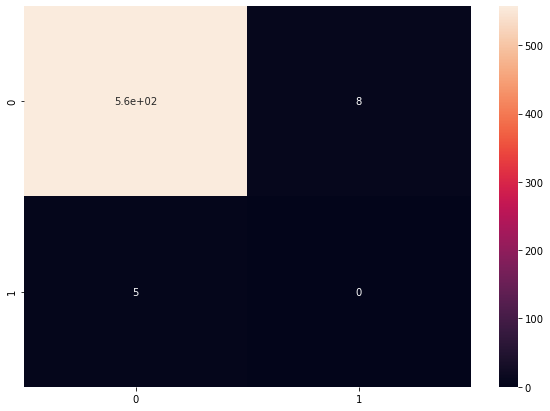

In [ ]:
plt.figure(figsize = (10,7))
cm = confusion_matrix(y_test, test_preds)
sn.heatmap(cm, annot=True)

In [ ]:
## still poor test performance, try a different approach

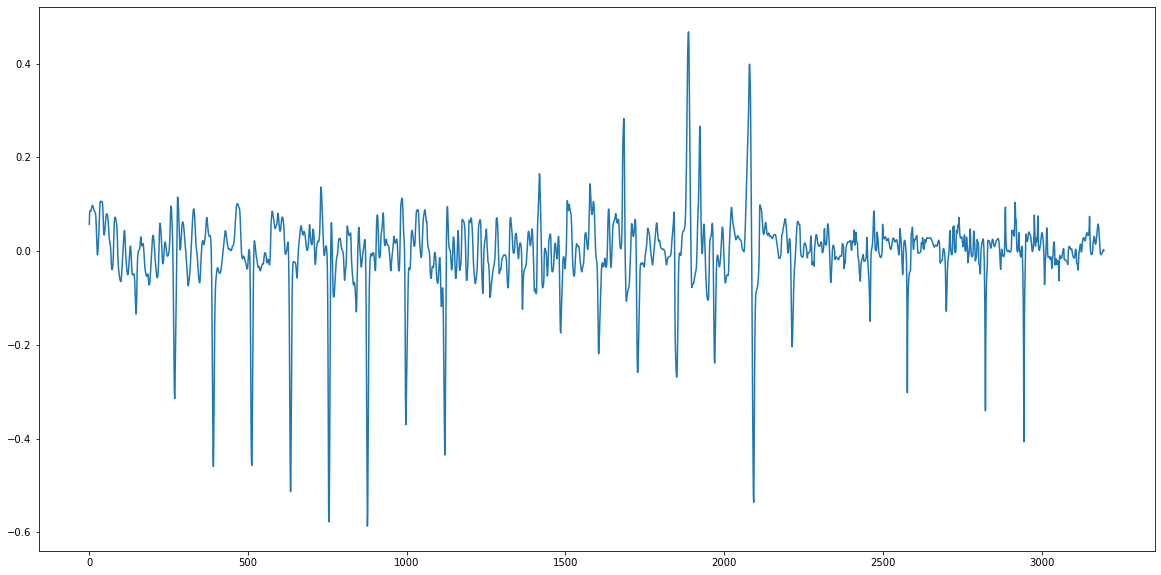

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(X_new_sampled[6540])
#plt.plot(X_sampled.iloc[6540].values)

In [ ]:
# find an array to get the diffs of a signal
max_shape = 0
for i, r in enumerate(X_new_sampled):
    p = signal.find_peaks(r, height = 0.3*max(r))
    shap = len(np.diff(p[0]))
    if(shap>max_shape):
        max_shape = shap
    
    

In [ ]:
new_data = np.zeros((X_new_sampled.shape[0], max_shape))
print(max_shape)

176


In [ ]:
for i, r in enumerate(X_new_sampled):
    p = signal.find_peaks((r), height = 0.3*max(r))
    diffs = (np.diff(p[0]))
    needed = max_shape - len(diffs)
    diffs = np.pad(diffs, (0, needed), constant_values = (0, np.mean(diffs)))
    new_data[i,:] = diffs

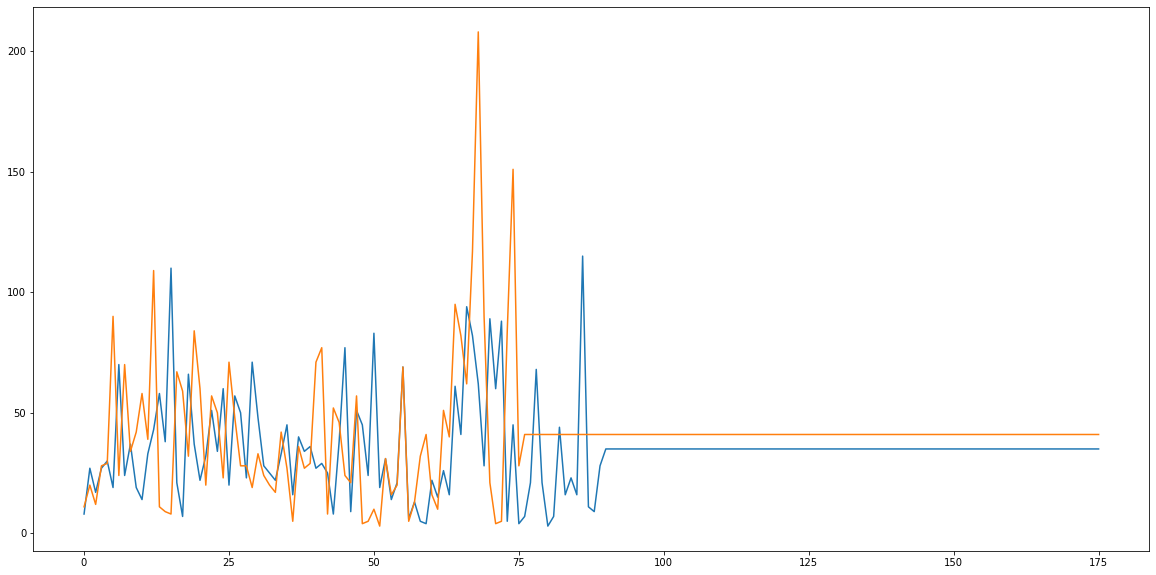

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(new_data[9403])
plt.plot(new_data[2340])

In [16]:
def get_fft_spectrum(signal):
    Fs = 1
    n = len(signal) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[:len(frq)//2] # one side frequency range

    Y = np.fft.fft(signal)/n # dft and normalization
    Y = Y[:n//2]

    return frq, abs(Y)

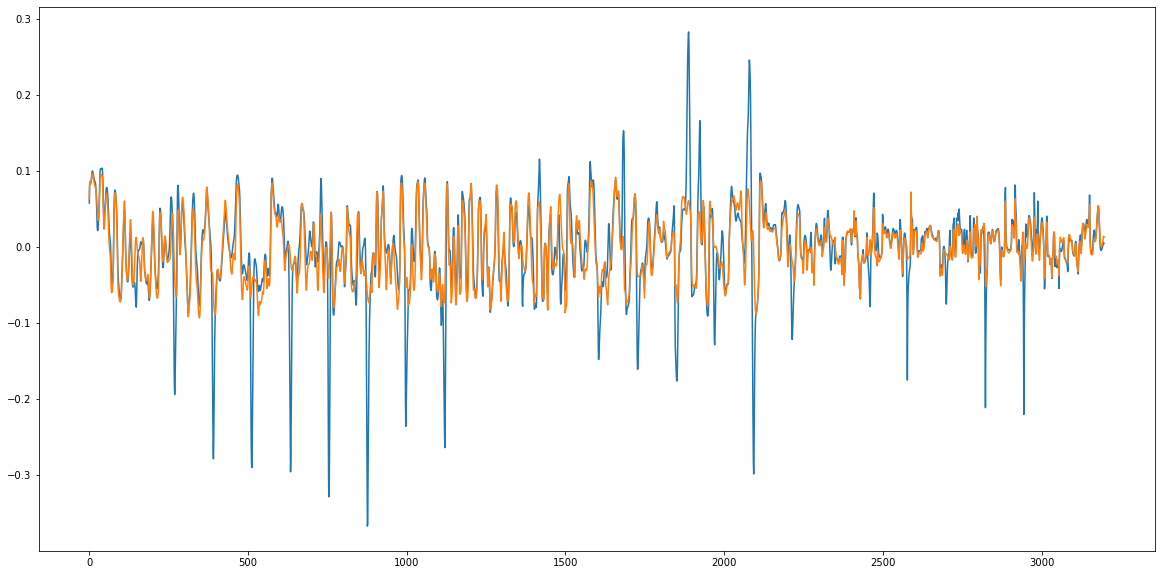

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(X_new_sampled[7120])
plt.plot(X_new_sampled[1203]) 

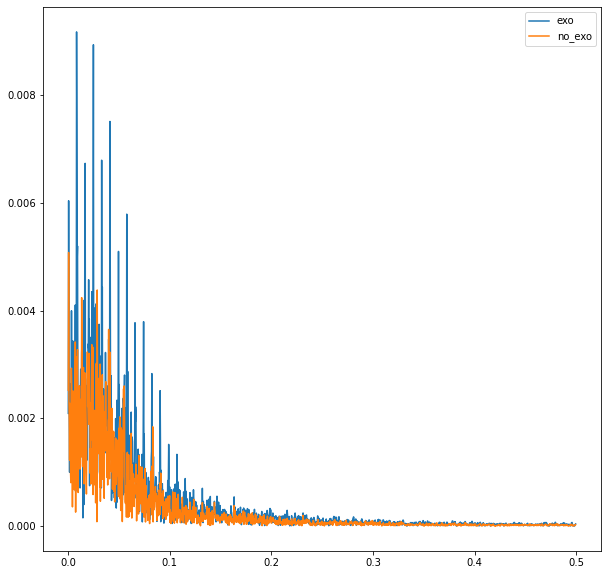

In [ ]:
s1 = get_fft_spectrum(X_new_sampled[7120])
s2 = get_fft_spectrum(X_new_sampled[1203])

plt.figure(figsize = (10,10))
plt.plot(s1[0], s1[1], label ='exo')
plt.plot(s2[0], s2[1], label = 'no_exo') # plotting the spectrum
plt.legend()


In [ ]:
exo_max = []
n_exo_max = []

for i, r in enumerate(X_new_sampled):
    fft = get_fft_spectrum(r)
    large = fft[1][np.argmax(fft[1])]
    print(len(fft[1]))
    if(y_sampled[i] ==1):
        n_exo_max.append(large)
    elif(y_sampled[i]==2):
        exo_max.append(large)

1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598


1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598
1598


KeyboardInterrupt: 

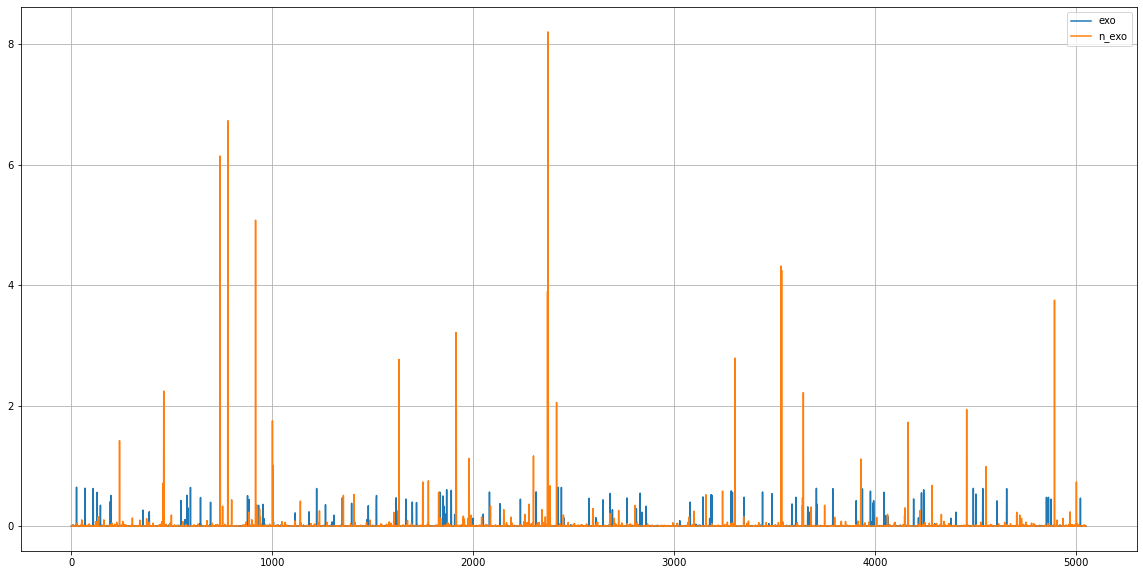

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(exo_max, label = 'exo')
plt.plot(n_exo_max, label = 'n_exo')
plt.legend()
plt.grid()

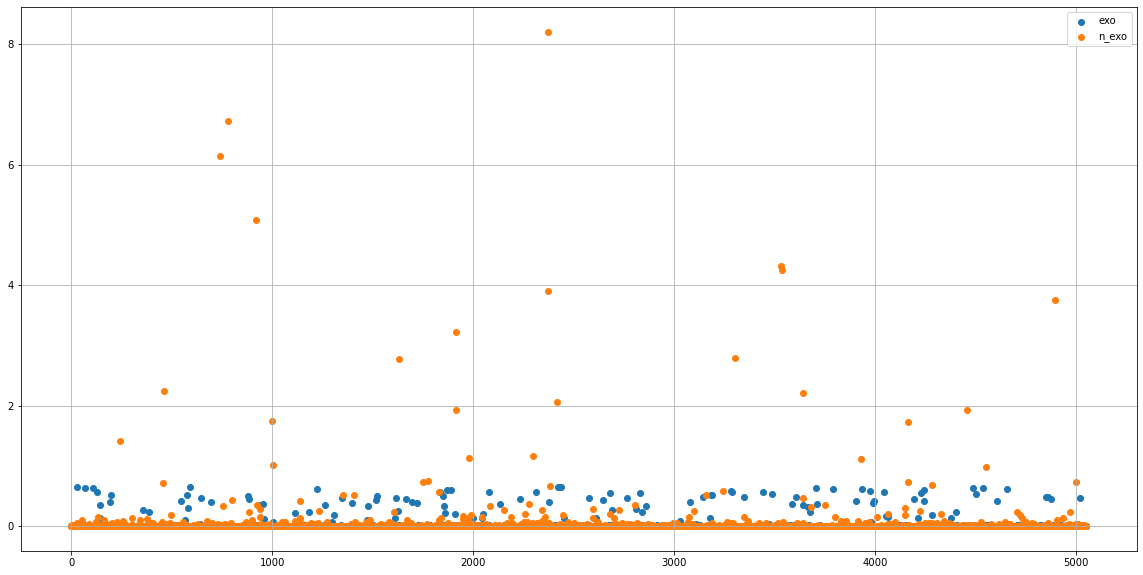

In [ ]:
plt.figure(figsize = (20,10))
plt.scatter(list(range(0, len(exo_max))), exo_max, label = 'exo')
plt.scatter(list(range(0,len(n_exo_max))),n_exo_max, label = 'n_exo')
plt.legend()
plt.grid()

In [ ]:
fft_data = np.zeros((X_new_sampled.shape[0], 1598))
for i, r in enumerate(X_new_sampled):
    fft = get_fft_spectrum(r)
    fft_data[i,:] = fft[1]

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=600, verbose = 3).fit(fft_data, y_sampled)


train_preds = clf.predict(fft_data)
print(classification_report(train_preds, y_sampled))

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

plt.figure(figsize = (10,7))
cm = confusion_matrix(y_sampled, train_preds)
sn.heatmap(cm, annot=True)

Iteration 1, loss = 0.68922634
Iteration 2, loss = 0.68380566
Iteration 3, loss = 0.68072448
Iteration 4, loss = 0.67756451
Iteration 5, loss = 0.67444325
Iteration 6, loss = 0.67122826
Iteration 7, loss = 0.66786130
Iteration 8, loss = 0.66399674
Iteration 9, loss = 0.66078189
Iteration 10, loss = 0.65619410
Iteration 11, loss = 0.65139662
Iteration 12, loss = 0.64603020
Iteration 13, loss = 0.64115997
Iteration 14, loss = 0.63555078
Iteration 15, loss = 0.62979653
Iteration 16, loss = 0.62384839
Iteration 17, loss = 0.61807502
Iteration 18, loss = 0.61209541
Iteration 19, loss = 0.60645568
Iteration 20, loss = 0.60061650
Iteration 21, loss = 0.59572435
Iteration 22, loss = 0.58930971
Iteration 23, loss = 0.58372083
Iteration 24, loss = 0.57916569
Iteration 25, loss = 0.57589399
Iteration 26, loss = 0.56848049
Iteration 27, loss = 0.56398140
Iteration 28, loss = 0.55947084
Iteration 29, loss = 0.55367125
Iteration 30, loss = 0.55041283
Iteration 31, loss = 0.54576294
Iteration 32, los

Iteration 253, loss = 0.13753989
Iteration 254, loss = 0.13636660
Iteration 255, loss = 0.13598050
Iteration 256, loss = 0.13498661
Iteration 257, loss = 0.13458303
Iteration 258, loss = 0.13391532
Iteration 259, loss = 0.13273324
Iteration 260, loss = 0.13328583
Iteration 261, loss = 0.13267281
Iteration 262, loss = 0.13109103
Iteration 263, loss = 0.13068188
Iteration 264, loss = 0.13013965
Iteration 265, loss = 0.12941892
Iteration 266, loss = 0.12848627
Iteration 267, loss = 0.12771297
Iteration 268, loss = 0.12725274
Iteration 269, loss = 0.12618705
Iteration 270, loss = 0.12601079
Iteration 271, loss = 0.12622211
Iteration 272, loss = 0.12520620
Iteration 273, loss = 0.12391006
Iteration 274, loss = 0.12359612
Iteration 275, loss = 0.12420102
Iteration 276, loss = 0.12206109
Iteration 277, loss = 0.12151605
Iteration 278, loss = 0.12190341
Iteration 279, loss = 0.12038307
Iteration 280, loss = 0.12039991
Iteration 281, loss = 0.11896827
Iteration 282, loss = 0.11865936
Iteration 

Iteration 502, loss = 0.05863593
Iteration 503, loss = 0.05947463
Iteration 504, loss = 0.05807133
Iteration 505, loss = 0.05836623
Iteration 506, loss = 0.05801113
Iteration 507, loss = 0.05733506
Iteration 508, loss = 0.05739079
Iteration 509, loss = 0.05770769
Iteration 510, loss = 0.05755298
Iteration 511, loss = 0.05694554
Iteration 512, loss = 0.05757197
Iteration 513, loss = 0.05682049
Iteration 514, loss = 0.05683494
Iteration 515, loss = 0.05698665
Iteration 516, loss = 0.05703368
Iteration 517, loss = 0.05653577
Iteration 518, loss = 0.05657830
Iteration 519, loss = 0.05659165
Iteration 520, loss = 0.05605185
Iteration 521, loss = 0.05628121
Iteration 522, loss = 0.05615115
Iteration 523, loss = 0.05663489
Iteration 524, loss = 0.05604476
Iteration 525, loss = 0.05649134
Iteration 526, loss = 0.05645650
Iteration 527, loss = 0.05581903
Iteration 528, loss = 0.05586201
Iteration 529, loss = 0.05540482
Iteration 530, loss = 0.05557265
Iteration 531, loss = 0.05628989
Iteration 

In [ ]:
X_test_scaled = np.zeros((X_new_test.shape[0], 1598))

for i, r in enumerate(X_new_test):
    fft = get_fft_spectrum(r)
    X_test_scaled[i,:] = fft[1]

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       569
           2       0.20      1.00      0.33         1

    accuracy                           0.99       570
   macro avg       0.60      1.00      0.66       570
weighted avg       1.00      0.99      1.00       570



<AxesSubplot:>

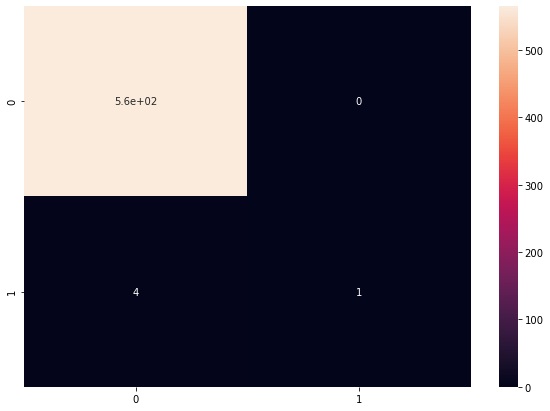

In [ ]:
test_preds = clf.predict(X_test_scaled)
print(classification_report(test_preds, y_test))

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

plt.figure(figsize = (10,7))
cm = confusion_matrix(y_test, test_preds)
sn.heatmap(cm, annot=True)

Iteration 1, loss = 0.68922634
Iteration 2, loss = 0.68380566
Iteration 3, loss = 0.68072448
Iteration 4, loss = 0.67756451
Iteration 5, loss = 0.67444325
Iteration 6, loss = 0.67122826
Iteration 7, loss = 0.66786130
Iteration 8, loss = 0.66399674
Iteration 9, loss = 0.66078189
Iteration 10, loss = 0.65619410
Iteration 11, loss = 0.65139662
Iteration 12, loss = 0.64603020
Iteration 13, loss = 0.64115997
Iteration 14, loss = 0.63555078
Iteration 15, loss = 0.62979653
Iteration 16, loss = 0.62384839
Iteration 17, loss = 0.61807502
Iteration 18, loss = 0.61209541
Iteration 19, loss = 0.60645568
Iteration 20, loss = 0.60061650
Iteration 21, loss = 0.59572435
Iteration 22, loss = 0.58930971
Iteration 23, loss = 0.58372083
Iteration 24, loss = 0.57916569
Iteration 25, loss = 0.57589399
Iteration 26, loss = 0.56848049
Iteration 27, loss = 0.56398140
Iteration 28, loss = 0.55947084
Iteration 29, loss = 0.55367125
Iteration 30, loss = 0.55041283
Iteration 31, loss = 0.54576294
Iteration 32, los

Iteration 253, loss = 0.13753989
Iteration 254, loss = 0.13636660
Iteration 255, loss = 0.13598050
Iteration 256, loss = 0.13498661
Iteration 257, loss = 0.13458303
Iteration 258, loss = 0.13391532
Iteration 259, loss = 0.13273324
Iteration 260, loss = 0.13328583
Iteration 261, loss = 0.13267281
Iteration 262, loss = 0.13109103
Iteration 263, loss = 0.13068188
Iteration 264, loss = 0.13013965
Iteration 265, loss = 0.12941892
Iteration 266, loss = 0.12848627
Iteration 267, loss = 0.12771297
Iteration 268, loss = 0.12725274
Iteration 269, loss = 0.12618705
Iteration 270, loss = 0.12601079
Iteration 271, loss = 0.12622211
Iteration 272, loss = 0.12520620
Iteration 273, loss = 0.12391006
Iteration 274, loss = 0.12359612
Iteration 275, loss = 0.12420102
Iteration 276, loss = 0.12206109
Iteration 277, loss = 0.12151605
Iteration 278, loss = 0.12190341
Iteration 279, loss = 0.12038307
Iteration 280, loss = 0.12039991
Iteration 281, loss = 0.11896827
Iteration 282, loss = 0.11865936
Iteration 

Iteration 502, loss = 0.05863593
Iteration 503, loss = 0.05947463
Iteration 504, loss = 0.05807133
Iteration 505, loss = 0.05836623
Iteration 506, loss = 0.05801113
Iteration 507, loss = 0.05733506
Iteration 508, loss = 0.05739079
Iteration 509, loss = 0.05770769
Iteration 510, loss = 0.05755298
Iteration 511, loss = 0.05694554
Iteration 512, loss = 0.05757197
Iteration 513, loss = 0.05682049
Iteration 514, loss = 0.05683494
Iteration 515, loss = 0.05698665
Iteration 516, loss = 0.05703368
Iteration 517, loss = 0.05653577
Iteration 518, loss = 0.05657830
Iteration 519, loss = 0.05659165
Iteration 520, loss = 0.05605185
Iteration 521, loss = 0.05628121
Iteration 522, loss = 0.05615115
Iteration 523, loss = 0.05663489
Iteration 524, loss = 0.05604476
Iteration 525, loss = 0.05649134
Iteration 526, loss = 0.05645650
Iteration 527, loss = 0.05581903
Iteration 528, loss = 0.05586201
Iteration 529, loss = 0.05540482
Iteration 530, loss = 0.05557265
Iteration 531, loss = 0.05628989
Iteration 

Iteration 751, loss = 0.04006549
Iteration 752, loss = 0.04016297
Iteration 753, loss = 0.04012498
Iteration 754, loss = 0.03992927
Iteration 755, loss = 0.03964667
Iteration 756, loss = 0.04013413
Iteration 757, loss = 0.04001532
Iteration 758, loss = 0.03979692
Iteration 759, loss = 0.03989205
Iteration 760, loss = 0.04009214
Iteration 761, loss = 0.03989150
Iteration 762, loss = 0.04008690
Iteration 763, loss = 0.04013742
Iteration 764, loss = 0.03933617
Iteration 765, loss = 0.03940035
Iteration 766, loss = 0.03942666
Iteration 767, loss = 0.03966852
Iteration 768, loss = 0.03944943
Iteration 769, loss = 0.03937599
Iteration 770, loss = 0.03989724
Iteration 771, loss = 0.03966287
Iteration 772, loss = 0.03964841
Iteration 773, loss = 0.03971864
Iteration 774, loss = 0.03906019
Iteration 775, loss = 0.04062639
Iteration 776, loss = 0.03921898
Iteration 777, loss = 0.03951898
Iteration 778, loss = 0.03978065
Iteration 779, loss = 0.03911202
Iteration 780, loss = 0.03889605
Iteration 

<AxesSubplot:>

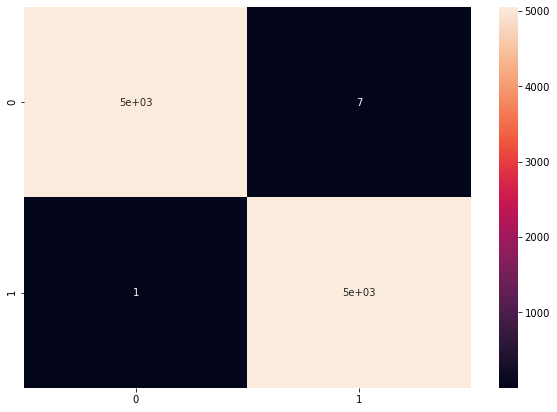

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=800, verbose = 3, tol =0.0000001).fit(fft_data, y_sampled)


train_preds = clf.predict(fft_data)
print(classification_report(train_preds, y_sampled))

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

plt.figure(figsize = (10,7))
cm = confusion_matrix(y_sampled, train_preds)
sn.heatmap(cm, annot=True)

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       569
           2       0.20      1.00      0.33         1

    accuracy                           0.99       570
   macro avg       0.60      1.00      0.66       570
weighted avg       1.00      0.99      1.00       570



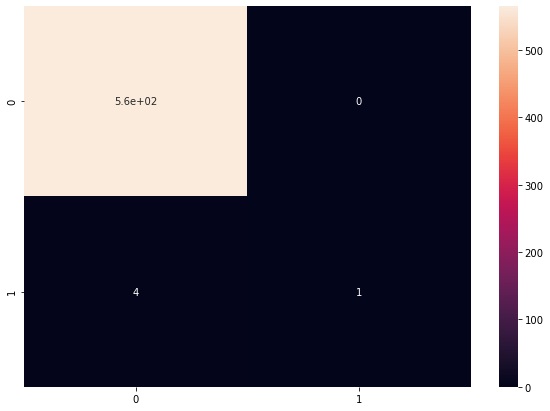

In [ ]:
test_preds = clf.predict(X_test_scaled)
print(classification_report(test_preds, y_test))

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

plt.figure(figsize = (10,7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm = confusion_matrix(y_test, test_preds)
sn.heatmap(cm, annot=True)
plt.show()

In [164]:
X_new_test.shape

(570,)

## NEW PROCESS: NEURAL NETWORK AND PROCESSING

In [5]:
## dataset process for NN



train = pd.read_csv('gdrive/My Drive/exoTrain.csv')
test = pd.read_csv('gdrive/My Drive/exoTest.csv')


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal
from scipy.signal import savgol_filter
from  scipy import ndimage
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize 
from scipy.ndimage.filters import uniform_filter1d
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam, SGD
from keras import metrics, regularizers
from keras.callbacks import EarlyStopping
from keras import backend as K
import keras
import seaborn as sn
import math
import timeit
import tensorflow as tf

In [141]:
y_train = train.LABEL
X_train = train.drop('LABEL',axis=1)
y_test = test.LABEL
X_test = test.drop('LABEL',axis=1)

In [142]:
def reduce_upper_outliers(df,reduce = 0.01, half_width=4):
    length = len(df.iloc[0,:])
    remove = int(length*reduce)
    for i in df.index.values: #Para cada muestra
        values = df.loc[i,:]
        sorted_values = values.sort_values(ascending = False)
        for j in range(remove): 
            idx = sorted_values.index[j]
            new_val = 0
            count = 0
            idx_num = int(idx[5:])
            for k in range(2*half_width+1):
                idx2 = idx_num + k - half_width
                if idx2 <1 or idx2 >= length or idx_num == idx2:
                    continue
                new_val += values['FLUX.'+str(idx2)]

                count += 1
            new_val /= count # count will always be positive here
            if new_val < values[idx]: # just in case there's a few persistently high adjacent values
                df.at[i,idx] = new_val
    return df
def iterar_ruo(df, n=2):
    for i in range(n): 
        df2 = reduce_upper_outliers(df)
    return df2

# Applying Fast Fourier Transform (FFT)
def fourier_transform(df):
    df_fft = np.abs(np.fft.fft(df, axis=1))
    return df_fft
def apply_filter(df):
    filt = ndimage.filters.gaussian_filter(df, sigma=10)
    return filt
def apply_normalization(df_train, df_test):
    norm_train = normalize(df_train)
    norm_test = normalize(df_test)

    return pd.DataFrame(norm_train), pd.DataFrame(norm_test)
def apply_standarization(df_train, df_test):
    scaler = StandardScaler()
    norm_train = scaler.fit_transform(df_train)
    norm_test = scaler.transform(df_test)
    
    norm_train = pd.DataFrame(norm_train)
    norm_test = pd.DataFrame(norm_test)
    return norm_train, norm_test

In [143]:
X_train = iterar_ruo(X_train)
X_test = iterar_ruo(X_test)

fouriertrain = fourier_transform(X_train)
fouriertest = fourier_transform(X_test)

filtertrain = apply_filter(fouriertrain)
filtertest = apply_filter(fouriertest)

norm_train, norm_test  = apply_normalization(filtertrain, filtertest)

stand_train, stand_test = apply_standarization(norm_train, norm_test)


In [144]:
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

X_total = stand_train.copy()
os =  SMOTE(sampling_strategy='minority')
final_train_x, final_train_y = os.fit_sample(X_total, y_train)

print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(final_train_y)))


Distribution before resampling Counter({1: 5050, 2: 37})
Distribution labels after resampling Counter({2: 5050, 1: 5050})


In [145]:
upsampling.shape

(10100, 3197)

In [146]:
labels = np.zeros((final_train_y.shape[0], 2))
labels[np.arange(final_train_y.size),final_train_y-1] = 1

In [147]:
def create_model(X_samp, activation='relu', learn_rate=0.01):
    model = Sequential()
    model.add(Conv1D(filters = 16, input_shape = (X_samp.shape[1],1), kernel_size=(3), activation = activation, kernel_regularizer='l2', padding='same'))
    model.add(MaxPooling1D(pool_size = 2, strides = 2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(32, activation = activation, kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "sigmoid", kernel_regularizer='l2'))
    
    optimizer = Adam(lr=learn_rate)
    #Adam is a optimized version of a SGD (Stochastic Gradient Descendant) optimizer.
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    #binary_crossentropy is the go-to loss function for classification tasks, either balanced or imbalanced. 
    #It is the first choice when no preference is built from domain knowledge yet.
    return model

In [148]:
EPOCHS = 50
VAL_SPLIT = 0.2
BATCH_SIZE = 120
early_stop = EarlyStopping(monitor='val_loss')

In [149]:
final_train = np.expand_dims(final_train_x,axis=2)
final_test = np.expand_dims(stand_test,axis=2)


In [150]:
final_train.shape, labels.shape

((10100, 3197, 1), (10100, 2))

In [151]:
model = create_model(final_train)
start_time_train = timeit.default_timer()
baseline_history= model.fit(final_train, labels, validation_split = VAL_SPLIT, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)
upsampling_elapsed = timeit.default_timer() - start_time_train
print('Training time: ' + str(upsampling_elapsed))

Epoch 1/50
68/68 [==============================] - 11s 156ms/step - loss: 1.5937 - val_loss: 0.2500
Epoch 2/50
68/68 [==============================] - 10s 154ms/step - loss: 0.2609 - val_loss: 0.1716
Epoch 3/50
68/68 [==============================] - 10s 154ms/step - loss: 0.2313 - val_loss: 0.3452
Epoch 4/50
68/68 [==============================] - 10s 154ms/step - loss: 0.2963 - val_loss: 0.2010
Epoch 5/50
68/68 [==============================] - 10s 153ms/step - loss: 0.2531 - val_loss: 0.1314
Epoch 6/50
68/68 [==============================] - 10s 153ms/step - loss: 0.2751 - val_loss: 0.1276
Epoch 7/50
68/68 [==============================] - 11s 155ms/step - loss: 0.2155 - val_loss: 0.1577
Epoch 8/50
68/68 [==============================] - 10s 153ms/step - loss: 0.1671 - val_loss: 0.1756
Epoch 9/50
68/68 [==============================] - 10s 154ms/step - loss: 0.2133 - val_loss: 0.1547
Epoch 10/50
68/68 [==============================] - 10s 153ms/step - loss: 0.1749 - val_lo

In [152]:
train_predictions = model.predict(final_train)
train_preds = np.argmax(train_predictions, axis=1)

In [153]:
final_train_x.shape

(10100, 3197)

In [154]:
y_train = np.argmax(labels, axis =1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5039
           1       1.00      1.00      1.00      5061

    accuracy                           1.00     10100
   macro avg       1.00      1.00      1.00     10100
weighted avg       1.00      1.00      1.00     10100



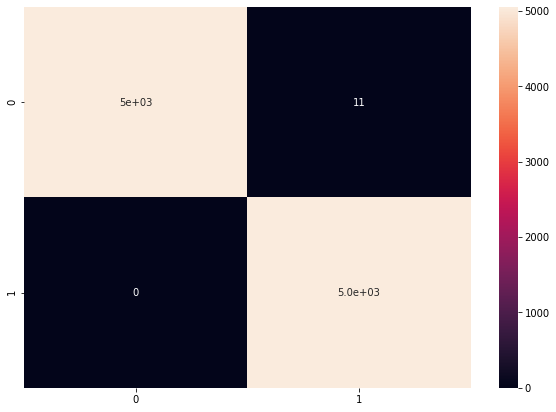

In [155]:
print(classification_report(train_preds, y_train))

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

plt.figure(figsize = (10,7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm = confusion_matrix(y_train, train_preds)
sn.heatmap(cm, annot=True)
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       567
           1       0.60      1.00      0.75         3

    accuracy                           1.00       570
   macro avg       0.80      1.00      0.87       570
weighted avg       1.00      1.00      1.00       570



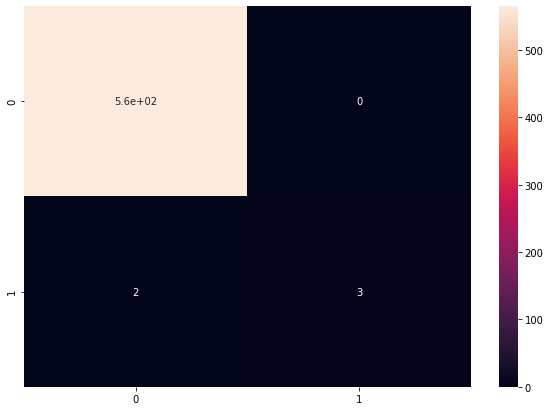

In [156]:
test_predictions = model.predict_classes(final_test)

print(classification_report(test_predictions, y_test-1))

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

plt.figure(figsize = (10,7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm = confusion_matrix(y_test-1, test_predictions)
sn.heatmap(cm, annot=True)
plt.show()

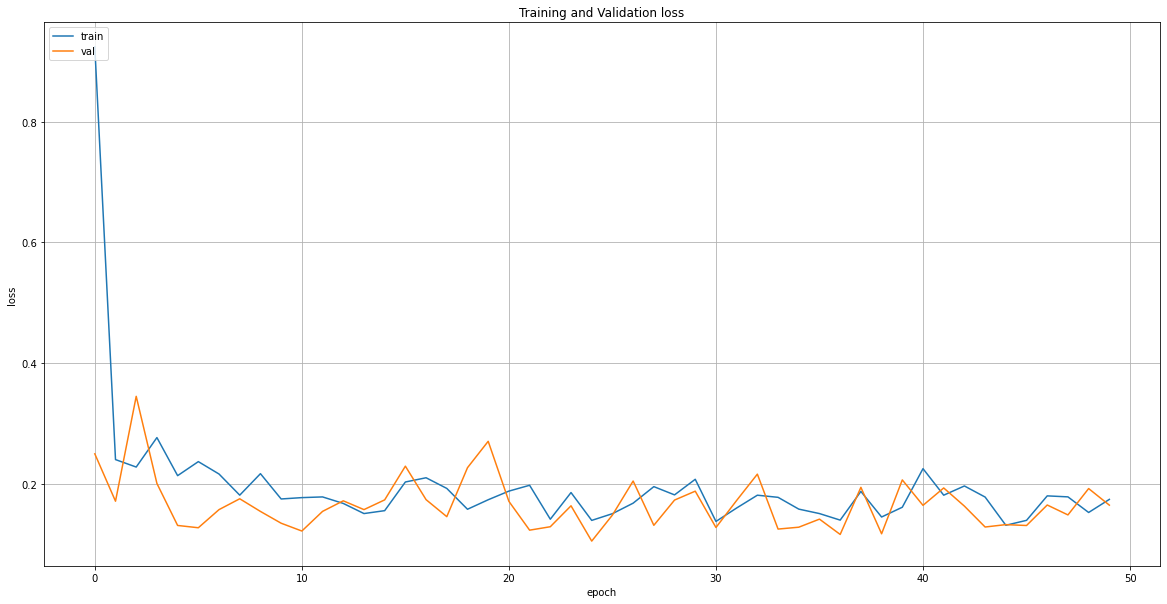

In [160]:
plt.figure(figsize = (20,10))
plt.plot(baseline_history.history['loss'])
plt.plot(baseline_history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
